In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jax import random
from PIL import Image
from splotch import get_input_data, register, run_nuts, run_svi, savagedickey

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

Image.MAX_IMAGE_PIXELS = 1000000000

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
def plot_coefficients(splotch_input_data, splotch_result, gene):
    data = splotch_result.posterior_samples["beta_level_1"][
        splotch_result.genes.index(gene)
    ]
    aars = splotch_input_data.aars()

    fig = plt.figure()
    fig.set_size_inches(3, 2 * len(aars))
    for aar_idx in range(len(aars)):
        ax = fig.add_subplot(len(aars), 1, aar_idx + 1)
        savage_dickey_density_ratio = savagedickey(
            data[:, 0, aar_idx],
            data[:, 1, aar_idx],
        )
        ax.set_title(
            f"{gene}\n{aars[aar_idx]}"
        )
        for idx in range(data.shape[1]):
            ax.hist(data[:, idx, aar_idx], 30, alpha=0.4)

    fig.set_tight_layout(True)


def plot_rates_on_slides(splotch_result, gene):
    rates_s = splotch_result.rates.loc[gene, :].mean(1)
    vmin, vmax = 0, np.percentile(rates_s, 95)

    for count_file in splotch_result.metadata.index.get_level_values(
        "count_file"
    ).unique():
        fig = plt.figure()
        fig.set_size_inches(3, 3)

        ax = fig.add_subplot(1, 1, 1)

        tissue_image = Image.open(
            splotch_result.metadata.query("count_file == @count_file").image_file.iloc[
                0
            ]
        )

        xdim, ydim = tissue_image.size

        # downsample the image
        tissue_image = tissue_image.resize(
            (np.round(xdim * 0.05).astype(int), np.round(ydim * 0.05).astype(int))
        )

        xdim, ydim = tissue_image.size
        pixel_dim = 194.0 / (6200.0 / xdim)

        x = pixel_dim * (
            splotch_result.metadata.query("count_file == @count_file").x - 1
        )
        y = pixel_dim * (
            splotch_result.metadata.query("count_file == @count_file").y - 1
        )
        c = rates_s[count_file]

        ax.imshow(tissue_image, origin="upper", interpolation="none", alpha=0.6)

        cb = ax.scatter(
            x, y, s=4, c=c, cmap="viridis", vmin=vmin, vmax=vmax, marker="o", alpha=0.9
        )

        ax.set_aspect("equal")

        ax.set_xticks([])
        ax.set_yticks([])

        ax.set_title(
            f"{splotch_result.metadata.query('count_file == @count_file').level_1.iloc[0]}"
        )

        cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
        cbar.set_label(f"λ ({gene})")


def plot_rates_in_common_coordinate_system(splotch_result, gene):
    rates_s = splotch_result.rates.loc[gene, :].mean(1)
    vmin, vmax = 0, np.percentile(rates_s, 95)

    for level_1_category in splotch_result.metadata.level_1.unique():
        fig = plt.figure()
        fig.set_size_inches(3, 3)

        ax = fig.add_subplot(1, 1, 1)

        x = splotch_result.metadata.query("level_1 == @level_1_category").x_registration
        y = splotch_result.metadata.query("level_1 == @level_1_category").y_registration
        c = rates_s[splotch_result.metadata.query("level_1 == @level_1_category").index]

        cb = ax.scatter(
            x, y, s=4, c=c, cmap="viridis", vmin=vmin, vmax=vmax, marker="o", alpha=0.9
        )

        ax.set_aspect("equal")

        ax.set_xticks([])
        ax.set_yticks([])

        ax.set_title(f"{level_1_category}")

        cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
        cbar.set_label(f"λ ({gene})")


def plot_annotations_in_common_coordinate_system(splotch_input_data):
    fig = plt.figure()
    fig.set_size_inches(3, 3)

    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(
        splotch_input_data.metadata.x_registration,
        splotch_input_data.metadata.y_registration,
        c=splotch_input_data.annotations(),
        cmap="tab10",
        s=5,
        alpha=0.8,
    )

    ax.set_aspect("equal")

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title("AARs")

In [3]:
splotch_input_data = get_input_data("metadata.tsv", 1, min_detection_rate=0.1, max_num_spots_per_tissue_section=400)

In [4]:
key = random.PRNGKey(0)
key, key_ = random.split(key, 2)
register(key_, splotch_input_data, num_steps=10_000)

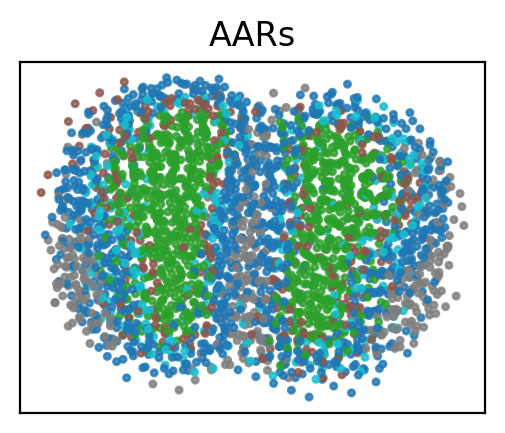

In [5]:
plot_annotations_in_common_coordinate_system(splotch_input_data)

In [6]:
splotch_input_data.metadata.groupby(
    ["level_1"], observed=True
).size().reset_index(name="num_spots").head()

level_1  num_spots
0       A       1061
1       B        263
2       C        454
3       D        452
4       E        813

In [7]:
splotch_input_data.metadata.groupby(
    ["level_1", "aar"], observed=True
).size().reset_index(name="num_spots").head()

level_1                    aar  num_spots
0       A       Glomerular layer        336
1       A    Granular Cell Layer        365
2       A      Mitral Cell Layer         99
3       A  Olfactory nerve layer        137
4       A  Outer Plexiform Layer        124

## NUTS

In [8]:
key = random.PRNGKey(0)
key, key_ = random.split(key)

splotch_result_nuts = run_nuts(
    key_,
    ["Camk4", "Tubb6"],
    splotch_input_data,
    map_method="pmap",
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
)

2023-12-14 21:11:56.877671: E external/xla/xla/service/collective_ops_utils.h:260] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{rank=2, element_count=12172000, type=F32, rendezvous_key=RendezvousKey{run_id=RunId: 4648, global_devices=[4,5,6,7], num_local_participants=4, collective_op_kind=cross_replica, op_id=321}} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 4648, global_devices=[4,5,6,7], num_local_participants=4, collective_op_kind=cross_replica, op_id=321}
2023-12-14 21:11:56.904874: E external/xla/xla/service/collective_ops_utils.h:260] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{rank=0, element_count=12172000, type=F32, rendezvous_key=RendezvousKey{run_id=RunId: 4648, global_devices=[4,5,6,7], num_local_participants=4, collective_op_kind=cross_replica, op_id=321}} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=

In [9]:
pd.concat(
    [
        splotch_result_nuts.inference_metrics["summary"][k].query("r_hat > 1.05")
        for k in splotch_result_nuts.inference_metrics["summary"]
    ],
    axis=0,
)

Empty DataFrame
Columns: [mean, std, median, 5.0%, 95.0%, n_eff, r_hat]
Index: []

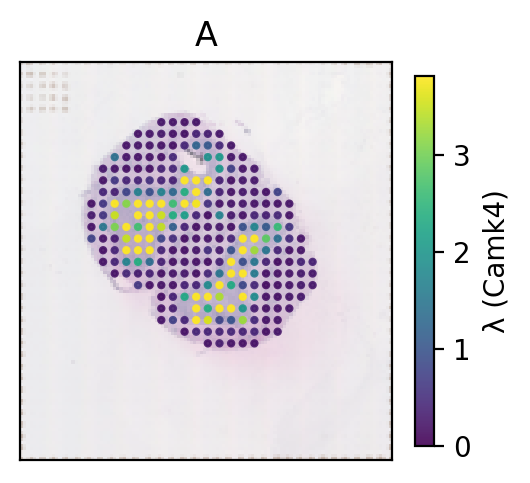

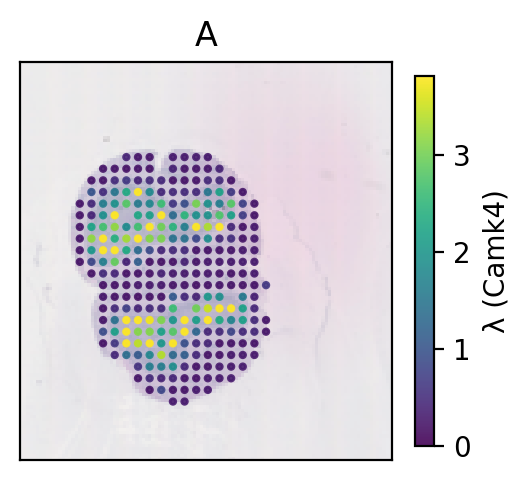

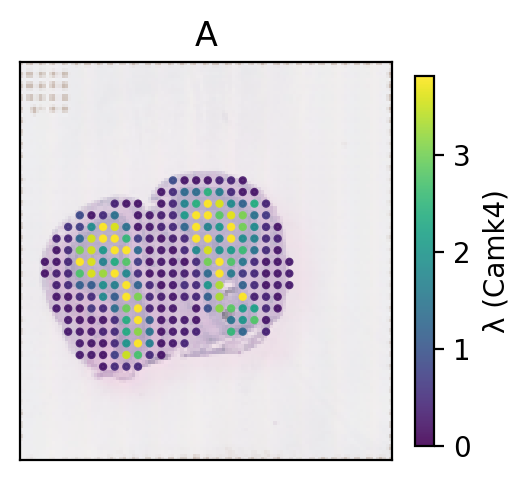

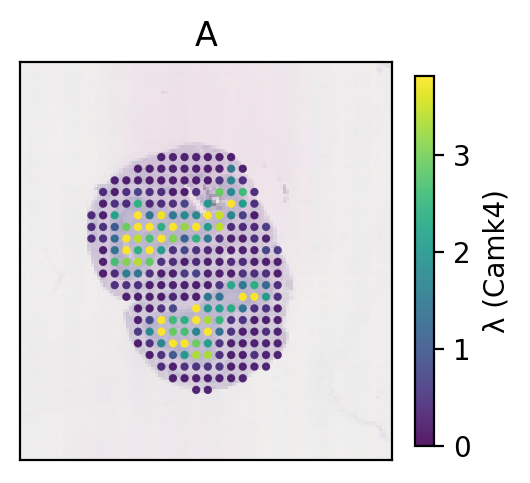

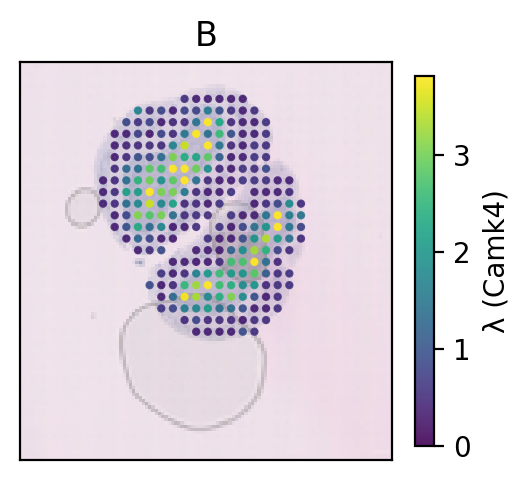

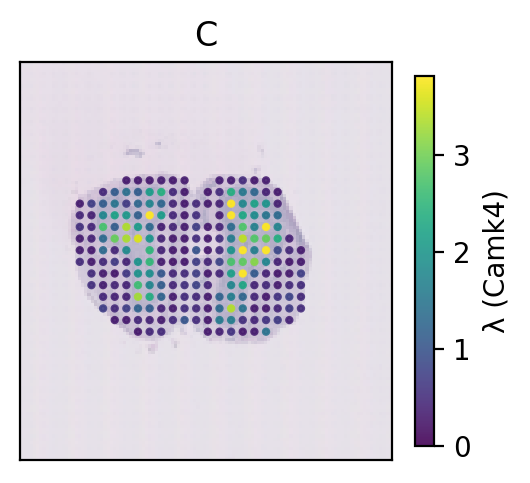

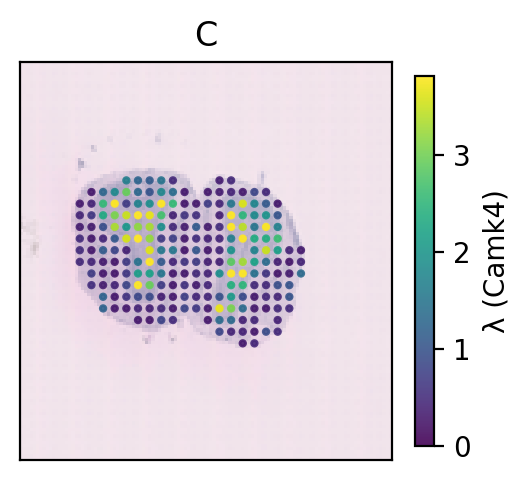

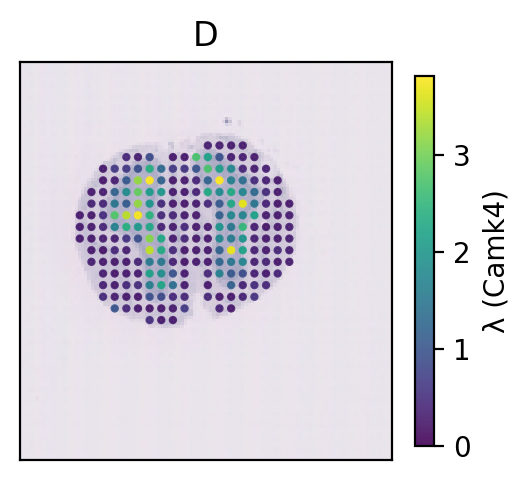

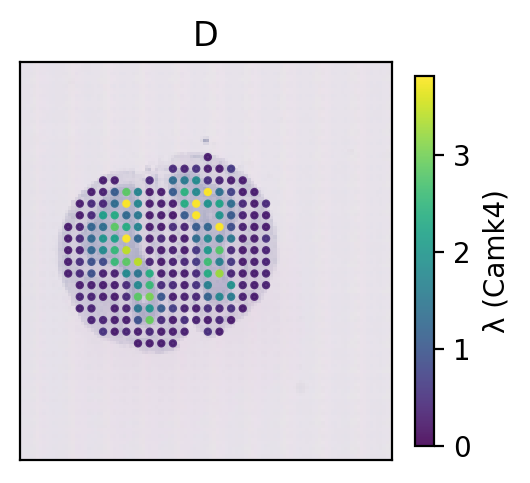

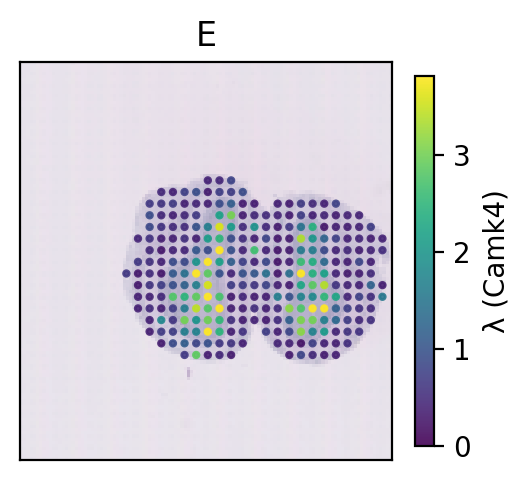

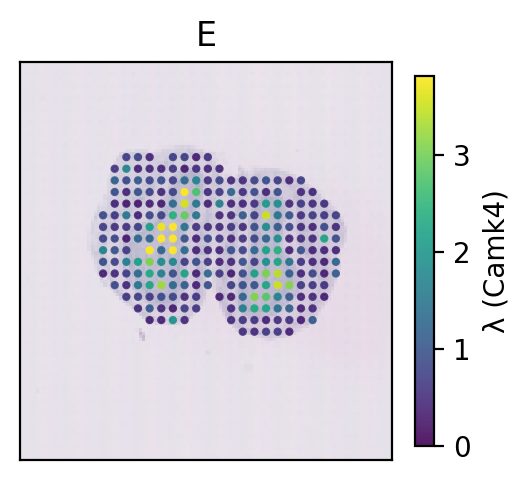

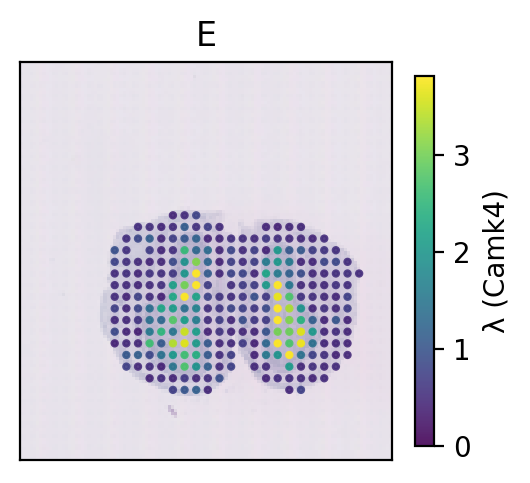

In [10]:
gene = "Camk4"

plot_rates_on_slides(splotch_result_nuts, gene)

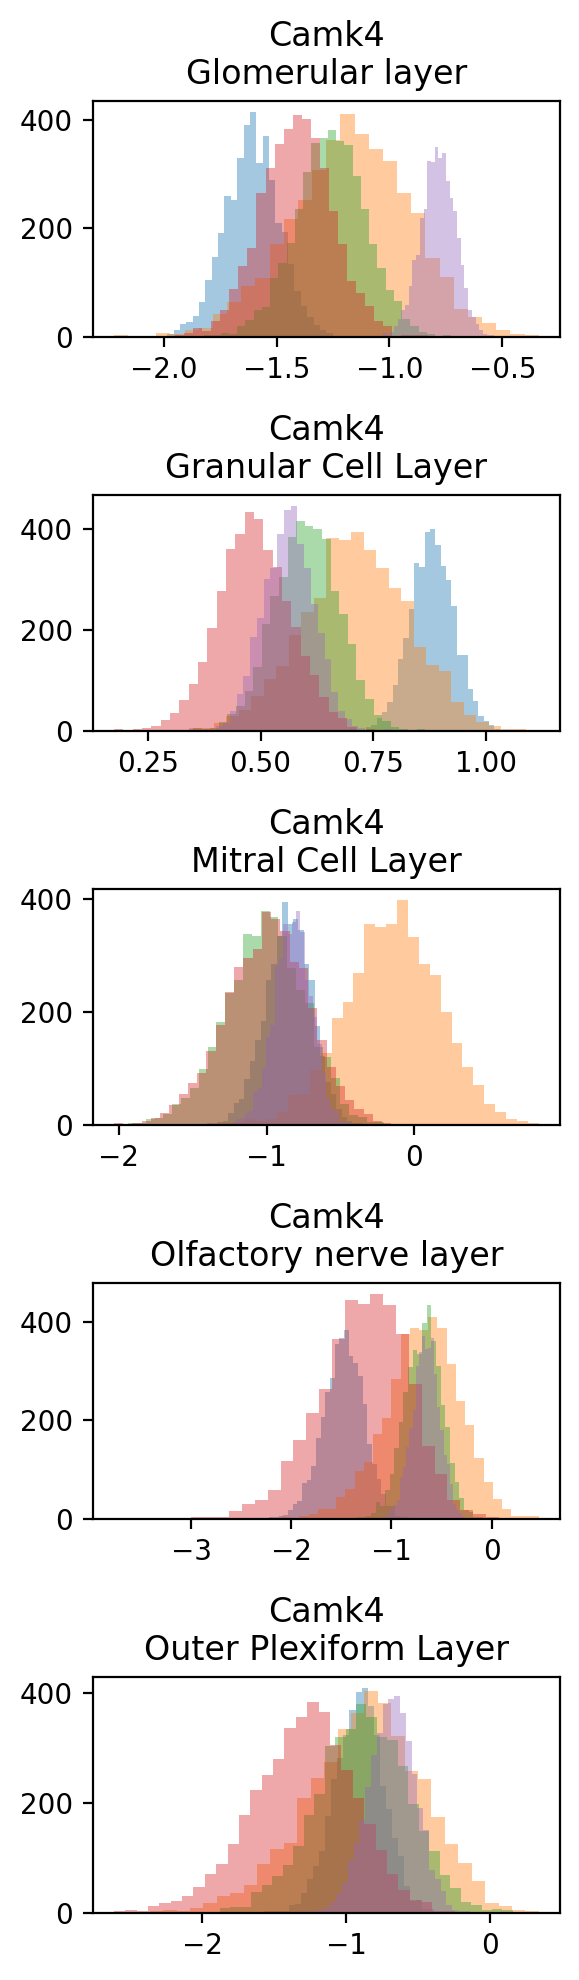

In [11]:
gene = "Camk4"

plot_coefficients(splotch_input_data, splotch_result_nuts, gene)

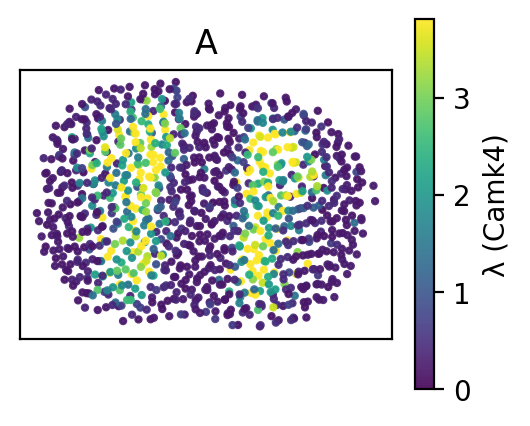

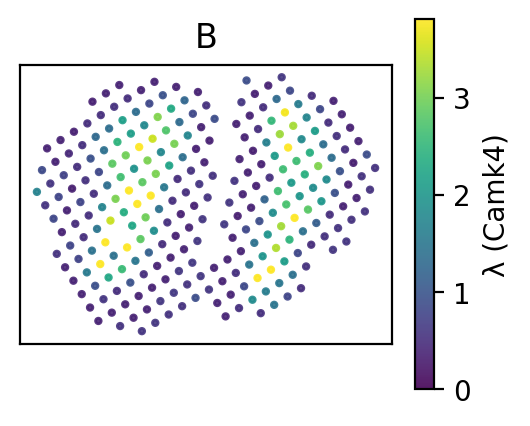

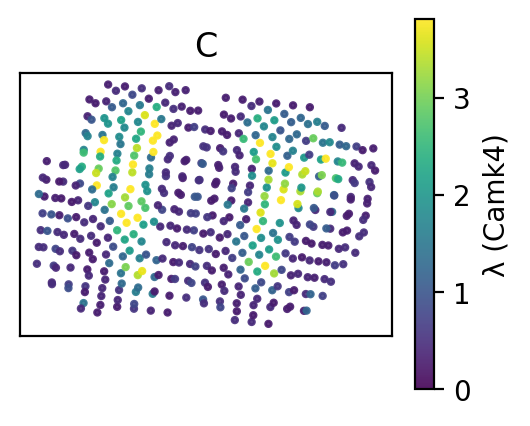

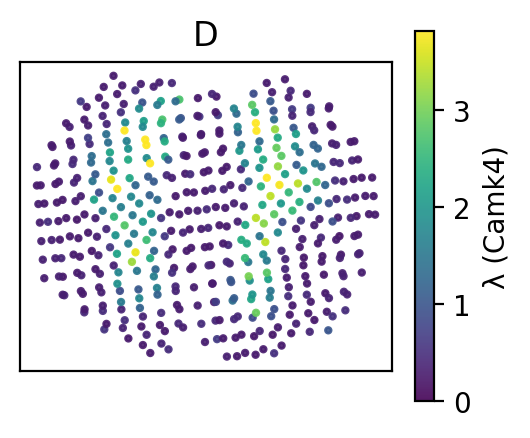

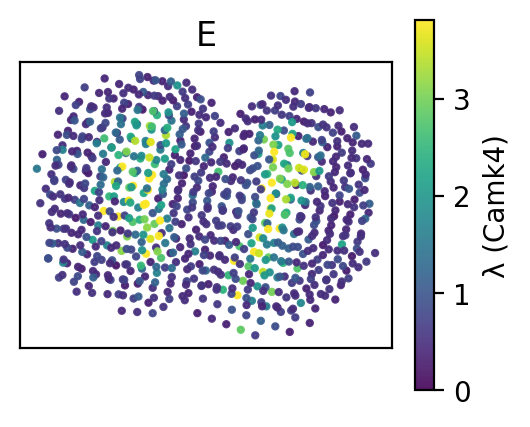

In [12]:
gene = "Camk4"

plot_rates_in_common_coordinate_system(splotch_result_nuts, gene)

## SVI

In [13]:
key = random.PRNGKey(0)
key, key_ = random.split(key)
splotch_result_svi = run_svi(
    key,
    ["Camk4"],
    splotch_input_data,
    map_method="map",
    num_steps=10_000,
    num_samples=1_000,
)

Text(0.5, 0, 'Iteration')

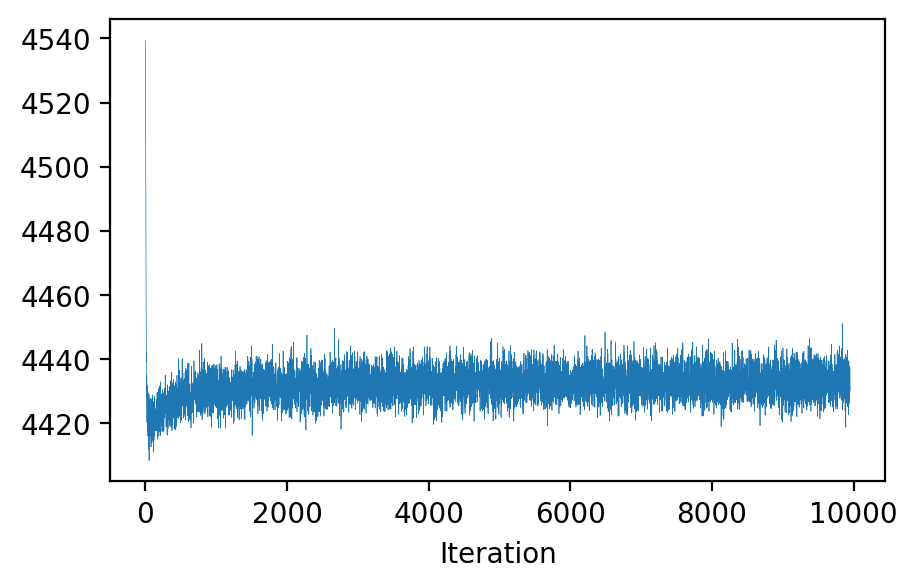

In [14]:
fig = plt.figure()
fig.set_size_inches(5, 3)

ax = fig.add_subplot(1, 1, 1)

ax.plot(splotch_result_svi.inference_metrics["losses"][0, 50:], lw=0.25)
ax.set_xlabel("Iteration")

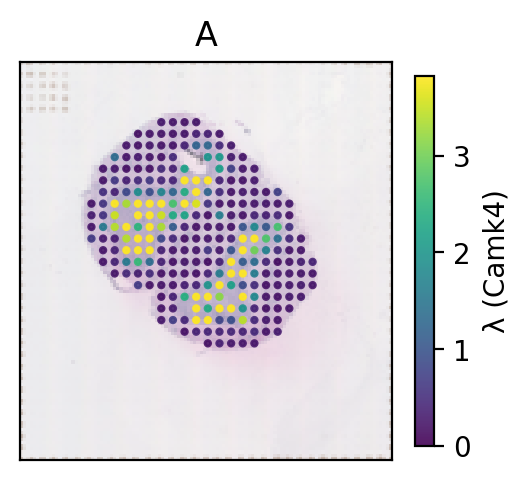

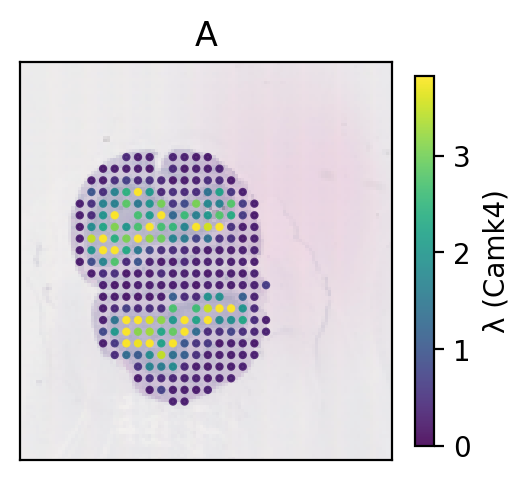

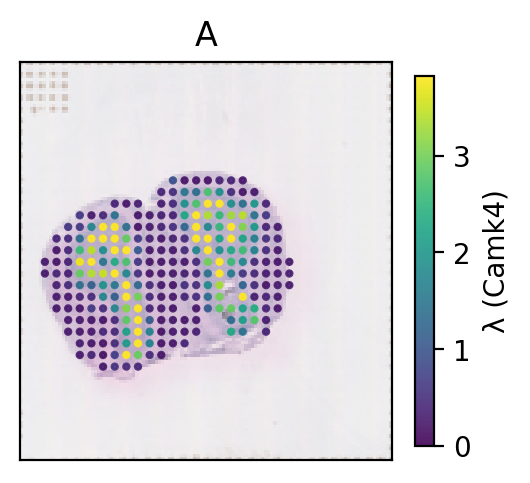

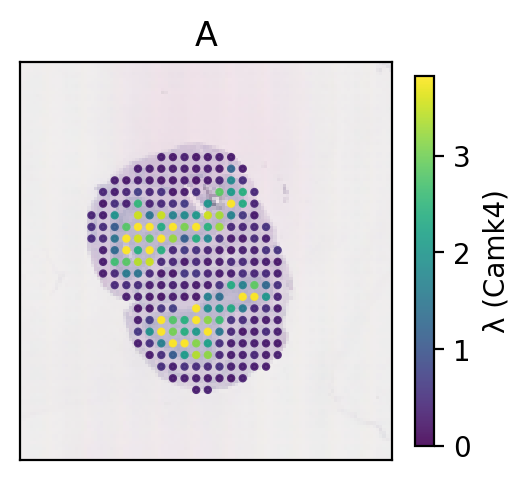

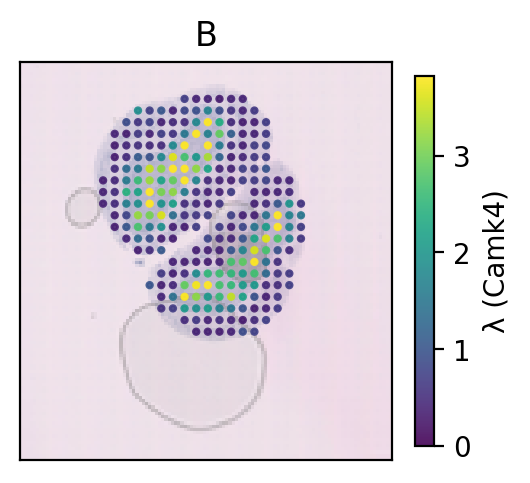

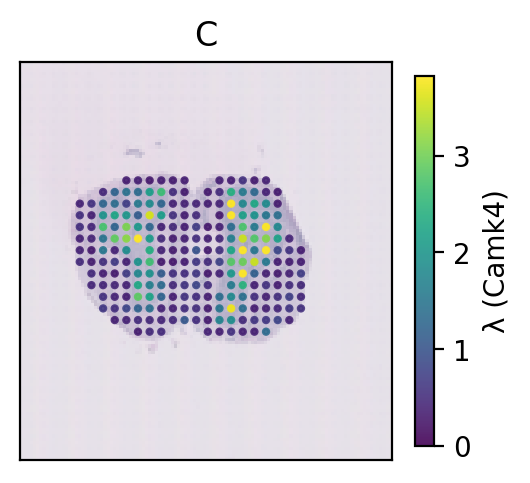

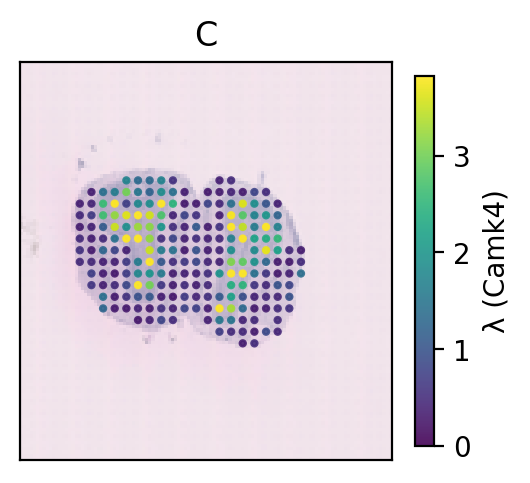

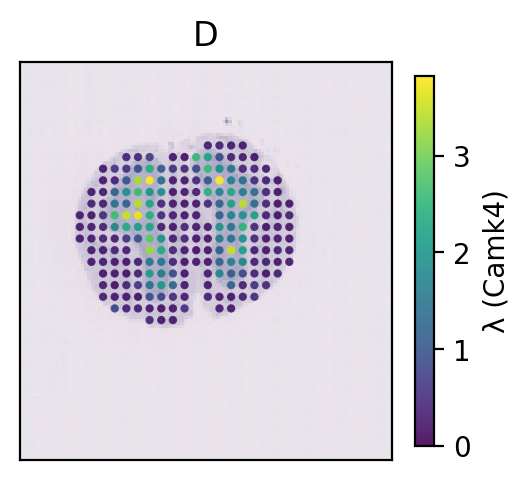

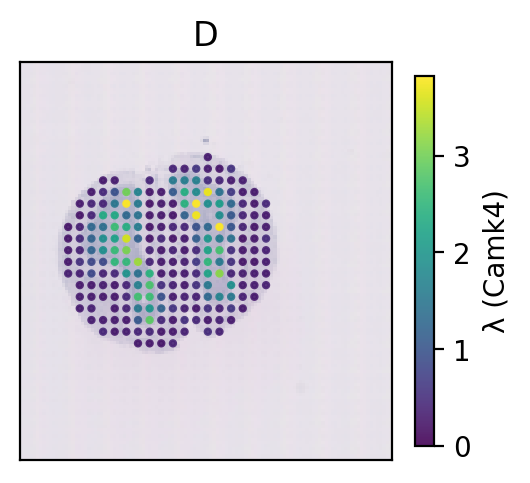

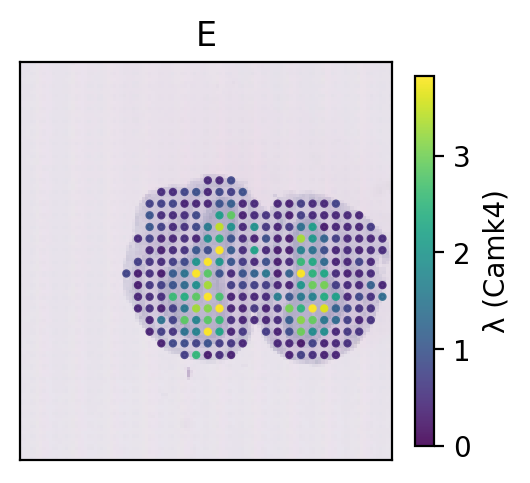

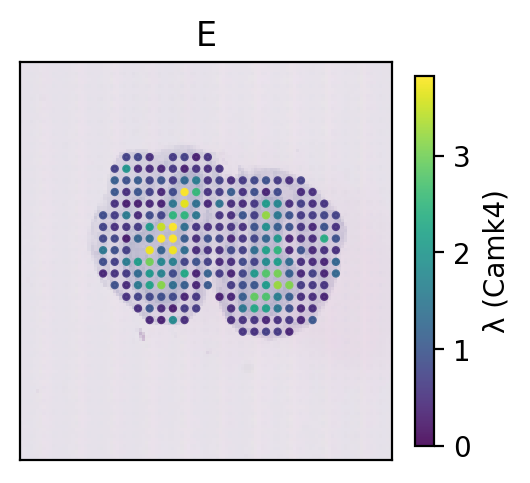

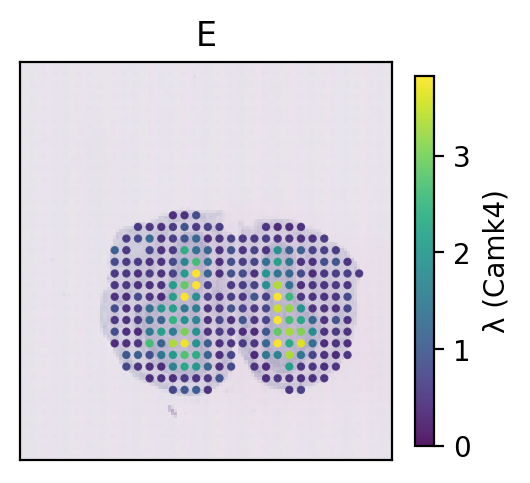

In [15]:
gene = "Camk4"

plot_rates_on_slides(splotch_result_svi, gene)

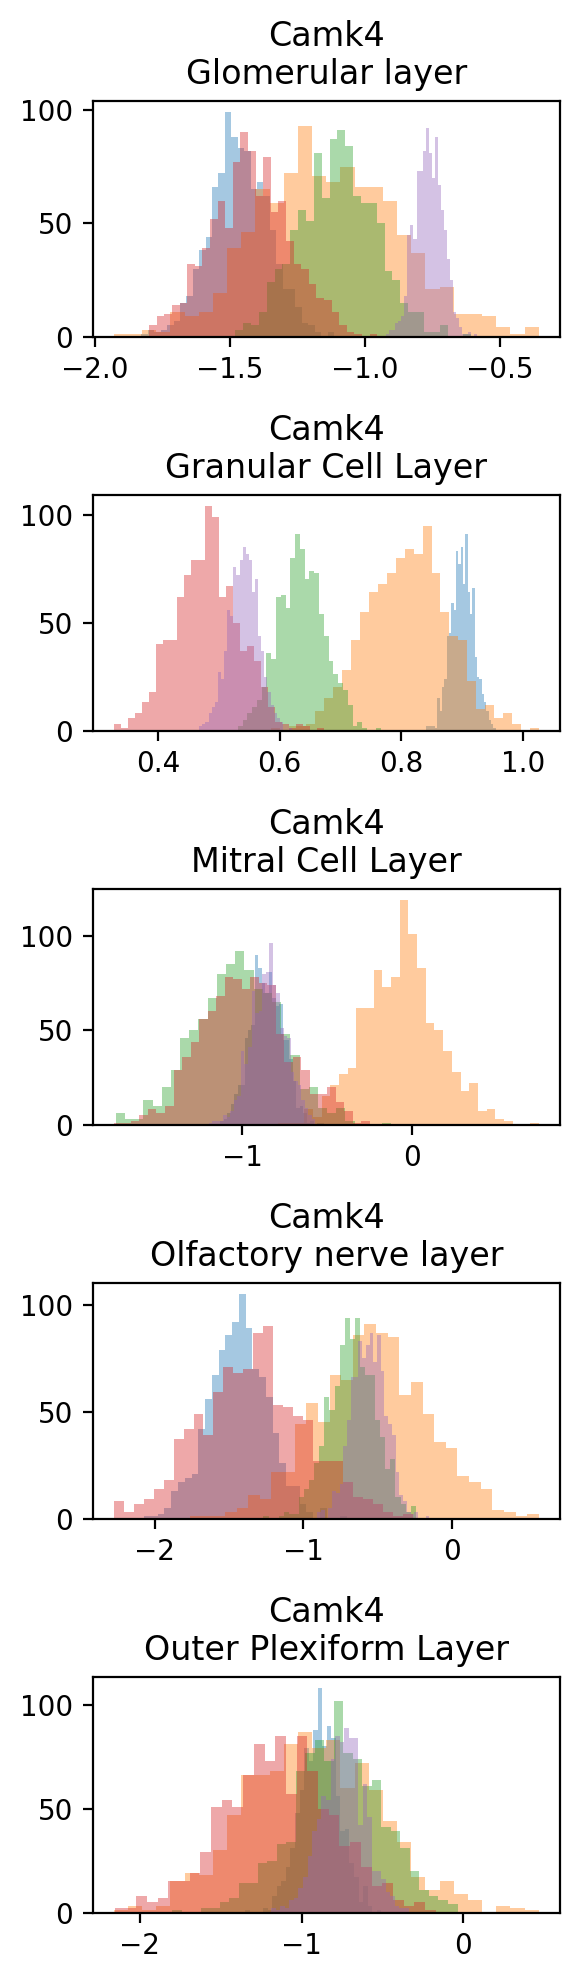

In [16]:
gene = "Camk4"

plot_coefficients(splotch_input_data, splotch_result_svi, gene)

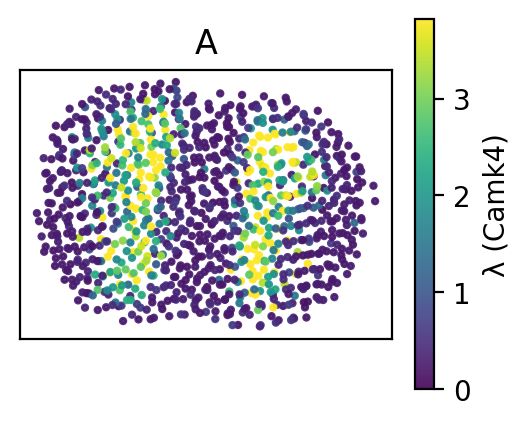

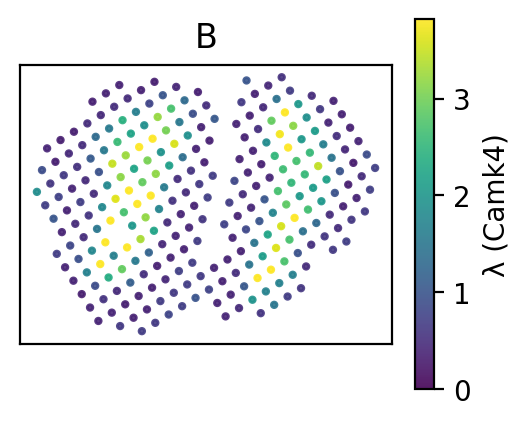

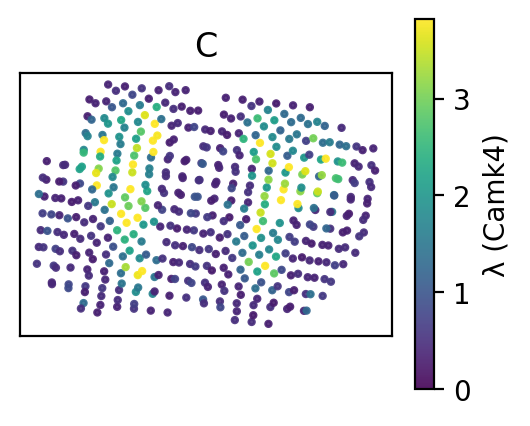

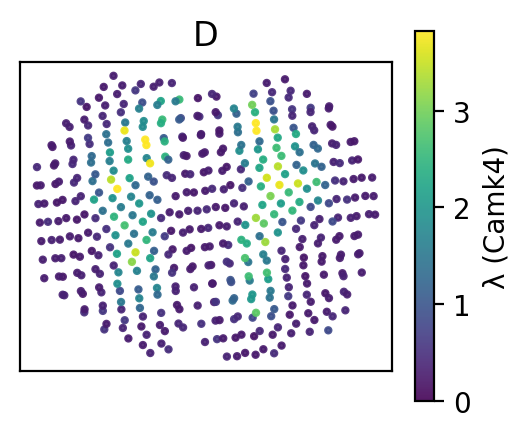

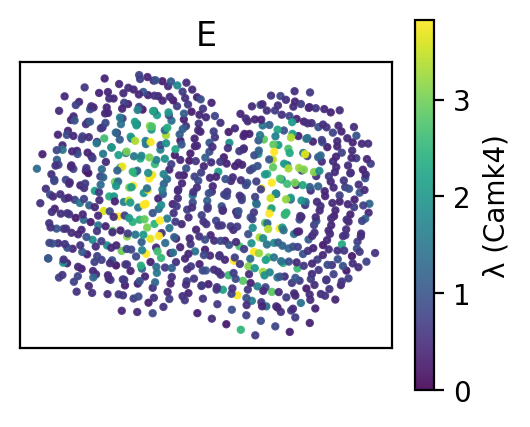

In [17]:
gene = "Camk4"

plot_rates_in_common_coordinate_system(splotch_result_svi, gene)